In [74]:
from Toolv1 import MotionGenerator, GenerateTraj,random_rot,traj_to_dist
from Toolv1 import diffusive,subdiffusive,directed,accelerated,slowed,still
from Toolv1 import diffusive_confined,subdiffusive_confined, continuous_time_random_walk
from Toolv1 import continuous_time_random_walk_confined
import numpy as np
ndim = 2
np.random.seed(6)
def add_miss_tracking(traj,N,f=10):
    
    step = traj[1:]-traj[:-1]
    
    std = np.average(np.sum(step**2,axis=1)**0.5)
    
    for i in range(N):
        w = np.random.randint(0,len(traj))
        traj[w] = np.random.normal(traj[w],f*std)
    
    return traj


def generate_N_nstep(N,nstep):
    add = 0
    index_zero = 8
    ndim = 2
    if ndim == 3:
        add = 1
    size = nstep
    
    X_train = np.zeros((N,size,5))
    Y_trains_b = np.zeros((N,size,9))
    Y_train_traj = []

    #12
    for i in range(N):
    #for i in range(1000):

        #if i % 1000 == 0:
        #    print i
        sigma = max(np.random.normal(0.5,1),0.05)
        step = max(np.random.normal(1,1),0.2)
        tryagain = True
        while tryagain:
            try:


                clean=False
                
                time=size
                ndim=2
                list_generator = [ MotionGenerator(time,ndim,
                                                  parameters=np.random.rand(3),
                                                  generate_motion=still),
                                  MotionGenerator(time,ndim,
                                                  parameters=np.random.rand(3),
                                                  generate_motion=subdiffusive_confined),
                                  MotionGenerator(time,ndim,
                                                  parameters=np.random.rand(3),
                                                  generate_motion=subdiffusive),
                                  MotionGenerator(time,ndim,
                                                  parameters=np.random.rand(3),
                                                  generate_motion=diffusive_confined),
                                  MotionGenerator(time,ndim,
                                                  parameters=np.random.rand(3),
                                                  generate_motion=diffusive),
                                MotionGenerator(time,ndim,
                                                  parameters=np.random.rand(3),
                                                  generate_motion=continuous_time_random_walk),
                                  MotionGenerator(time,ndim,
                                                  parameters=np.random.rand(3),
                                                  generate_motion=continuous_time_random_walk_confined),
                                  
                                  MotionGenerator(time,ndim,
                                                  parameters=np.random.rand(3),
                                                  generate_motion=directed) ]

                A = GenerateTraj(time,n_max=4,list_max_possible=[3,3,3,3,3,3,3,3],list_generator=list_generator)
 

                #Clean small seq
                all_states = set(A.sequence)
                n_states = [A.sequence.count(istate) for istate in all_states]
        
            
                for s,ns in zip(all_states,n_states):
                    A.sequence = np.array(A.sequence)
                    if size > 25 and ns < 10:
                        A.sequence[A.sequence == s] = "%i_0"%(index_zero)
                        
                
                def map_sequence(sequence):
                    ns = []
                    for iseque in  sequence:
                        i0,j0 = map(int,iseque.split("_"))
                        ns.append(i0)
                    return ns
                
                real_traj = A.traj
                sc = map_sequence(A.sequence)

                alpharot = 2*3.14*np.random.random()
                

                
                real_traj  = random_rot(real_traj,alpharot,ndim=ndim)
                

                #Noise
                dt = real_traj[1:]-real_traj[:-1]
                std = np.mean(np.sum(dt**2,axis=1)/3)**0.5  
                
                if std == 0 :
                    std = 1
                noise_level = 0.25*np.random.rand()
                real_traj += np.random.normal(0,noise_level*std,real_traj.shape)
                
                
                
                alligned_traj,normed,alpha,_ = traj_to_dist(real_traj,ndim=ndim)
                nzeros = np.random.randint(0,10)
                
                
                Z = []
                for _ in range(nzeros):
                    Z.append(np.random.randint(len(sc)-1))
                    sc[Z[-1]] = index_zero
           
                
                for i_isc,isc  in enumerate(sc):
                    if isc == index_zero:
                        normed[i_isc,::] = 0
                    
                    
                #print  alligned_traj.shape ,len(sc)
            
                tryagain=False
                
                
            except IndexError:
                tryagain=True
                
        Y_train_traj.append(real_traj)
        #print X_train.shape
        X_train[i] = normed
        
      
        Y_trains_b[i][range(time),np.array(sc,dtype=np.int)] = 1
  
        #print sc

    
    return X_train,Y_trains_b,Y_train_traj

print generate_N_nstep(100,600)[1].shape

(100, 600, 9)


In [73]:
# this returns a tensor
from keras.layers import Input, Embedding, LSTM, Dense, merge,TimeDistributed
from Bilayer import BiLSTMv1 as BiLSTM
from keras.models import Model

ncats = 6

inputs = Input(shape=(None,5),name="Input")

l1 = BiLSTM(output_dim=50,activation='tanh',return_sequences=True)(inputs)
l2 = BiLSTM(output_dim=50,activation='tanh',return_sequences=True)(merge([inputs,l1],mode="concat"))
l3 = BiLSTM(output_dim=50,activation='tanh',return_sequences=True)(merge([inputs,l2],mode="concat"))

brownian = BiLSTM(output_dim=50,activation='tanh',return_sequences=True,name="brownian_i")(merge([inputs,l1,l2,l3],mode="concat"))
brownian = TimeDistributed(Dense(9,activation="softmax"),name="brownian")(brownian)

model = Model(input=[inputs],output=[brownian])#,sigma])

model.compile(optimizer='adadelta',
              loss={'brownian': 'categorical_crossentropy'})
              #loss_weights={'sigma': .1, 'brownian': .9})
"""
model.compile(optimizer='adadelta',
              loss={ 'brownian': 'binary_crossentropy'})"""

"\nmodel.compile(optimizer='adadelta',\n              loss={ 'brownian': 'binary_crossentropy'})"

"\nmodel.compile(optimizer='adadelta',\n              loss={ 'brownian': 'binary_crossentropy'})"

In [60]:
#w = "ftest_2_135"
"""
w = 'ftest_rea_2_40'
try:
    model.load_weights("/home/jarbona/cluster_theano/"+w)
except:
    model.load_weights(w)"""

0
[[[ 0.50901252]
  [ 0.50268888]
  [ 0.49906114]
  [ 0.49648401]
  [ 0.49425328]
  [ 0.4921411 ]
  [ 0.49010983]
  [ 0.48817432]
  [ 0.48634967]
  [ 0.48463738]]

 [[ 0.50901252]
  [ 0.50268888]
  [ 0.49906114]
  [ 0.49648401]
  [ 0.49425328]
  [ 0.4921411 ]
  [ 0.49010983]
  [ 0.48817432]
  [ 0.48634967]
  [ 0.48463738]]

 [[ 0.50901252]
  [ 0.50268888]
  [ 0.49906114]
  [ 0.49648401]
  [ 0.49425328]
  [ 0.4921411 ]
  [ 0.49010983]
  [ 0.48817432]
  [ 0.48634967]
  [ 0.48463738]]

 [[ 0.50901252]
  [ 0.50268888]
  [ 0.49906114]
  [ 0.49648401]
  [ 0.49425328]
  [ 0.4921411 ]
  [ 0.49010983]
  [ 0.48817432]
  [ 0.48634967]
  [ 0.48463738]]

 [[ 0.50901252]
  [ 0.50268888]
  [ 0.49906114]
  [ 0.49648401]
  [ 0.49425328]
  [ 0.4921411 ]
  [ 0.49010983]
  [ 0.48817432]
  [ 0.48634967]
  [ 0.48463738]]

 [[ 0.50901252]
  [ 0.50268888]
  [ 0.49906114]
  [ 0.49648401]
  [ 0.49425328]
  [ 0.4921411 ]
  [ 0.49010983]
  [ 0.48817432]
  [ 0.48634967]
  [ 0.48463738]]

 [[ 0.50901252]
  [ 0.5026

In [13]:
import keras
import cPickle
class LossHistory(keras.callbacks.Callback):
    #losses = []
    #val_losses = []
    def __init__(self,name):
        super(LossHistory, self).__init__()
        self.name=name
        self.losses = []
        self.val_losses = []
    def on_train_begin(self, logs={}):
        
        pass
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        #self.val_losses.append(logs.get('val_loss'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        cPickle.dump((self.losses,self.val_losses), open(self.name, 'wb')) 
        


In [61]:
#from Specialist_layer import  return_three_layer,return_three_bis
#history = LossHistory("losses15.pick")
#TRaining of graph 1
#print lr
#lr = 0.1
lr = 1.0
wgraph = model
wgraph.optimizer.lr.set_value(lr)
for i in range(15):
    for j in range(0,6*6*4,1):
    
        modulo = 6
        size = (1 + j % modulo)*50
       
        if j % modulo == 4:
            size=200
        if j % modulo == 5:
            size=400    
        if j % modulo == 3:
            size=26
        """
        if j % modulo == 6:
            size=600   
        if j % modulo == 7:
            size=800   
        if j % modulo == 8:
            size=1000   
        if j % modulo == 9:
            size=1500   """
        #size=26
        
        
        print size
        
        try:
        
            X_train,Y_trains_b,scs = generate_N_nstep(4000,size)

            inp = {"Input":X_train}
            ret={"brownian":Y_trains_b}
            """#
            ret = {"input1":X_train,
                   "output":Y_trains,
                   "outputtype":convert_output(Y_trains),
                  "category":Y_train_cat[::,::,:12]}"""
            
        except:
            print "pb"
            pass
        #next(generator())
        
        #print ret["category"].shape
        if size == 400:
            wgraph.optimizer.lr.set_value(lr)
            print wgraph.optimizer.lr.get_value()
            
        if size == 50:
            wgraph.optimizer.lr.set_value(lr)
            print wgraph.optimizer.lr.get_value()
            
        """
        if size != 600:
            batch = 50
        else:
            batch = 20"""
        batch = 50
        #print ret.keys()
        #print ret["category"].shape, ret["output"].shape, 
        wgraph.fit(inp,ret,batch, nb_epoch=1,validation_split=0.05)#, callbacks=[history])
        
        if i == 3:
            lr = 0.1
        if j % modulo == 0 :
            name = "ftest_rea_continuous"
            wgraph.save_weights(name + "_%i_%i"%(i+2,j),overwrite=True)
            #sub_with_noise (30p)
        
            
            #if np.isnan(graph.evaluate(ret)):
            #    graph = return_three_layer()
            #    graph.load_weights("transition_l8_%i_diff_size_50"%(i+2))
    #if i % 3 == 0 and i != 0:
    #    lr /= 2.
    #    graph.optimizer.lr.set_value(lr)
    #    print graph.optimizer.lr.get_value()

#score = model.evaluate(X_test, Y_test, batch_size=16)

50
pb
0.10000000149


KeyboardInterrupt: 

In [9]:
w = 'ftest_rea_6_24'
try:
    model.load_weights("/home/jarbona/cluster_theano/"+w)
except:
    model.load_weights(w)
size=600
batch = 10
X_train,Y_trains_b,scs = generate_N_nstep(1000,size)
inp = {"Input":X_train}
ret={"brownian":Y_trains_b}

ValueError: could not broadcast input array from shape (511,5) into shape (600,5)

In [1]:
model.optimizer.lr.set_value(0.1)

model.fit(inp,ret,batch, nb_epoch=1,validation_split=0.05)#, callbacks=[history])

NameError: name 'model' is not defined

In [26]:
model.save_weights("test")

[WARNING] test already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True in save_weights!


In [6]:
size=100
X_train,Y_trains_b,scs = generate_N_nstep(200,size)

inp = {"Input":X_train}
ret={"brownian":Y_trains_b}

In [8]:
resp  = model.predict(inp["Input"][:20])


set([3, 5])
set([0, 3, 5])
set([3, 5])
set([1, 2, 3, 5])
set([1, 2, 5])
set([3, 5])
set([3, 5])
set([0, 2, 4, 5])
set([0, 5])
set([3, 4, 5])


'\nfigure()\nplot(resp[1][w][::,0])\nplot(ret["sigma"][w][::,0])\n'

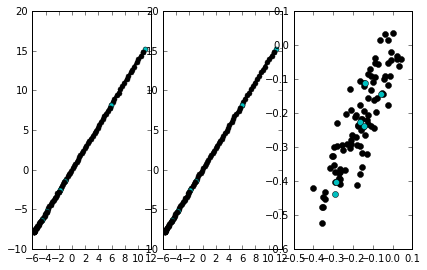

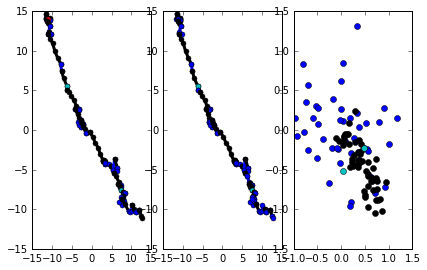

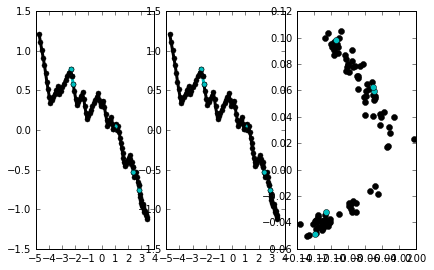

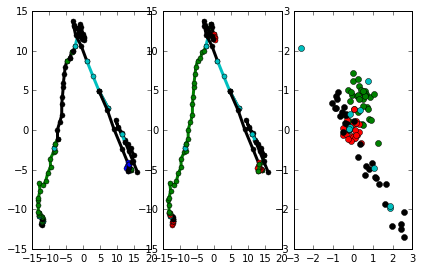

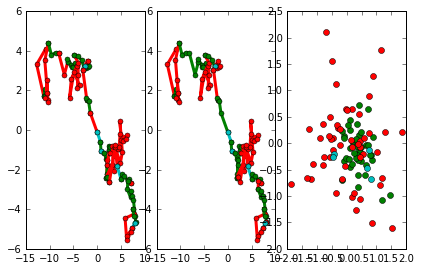

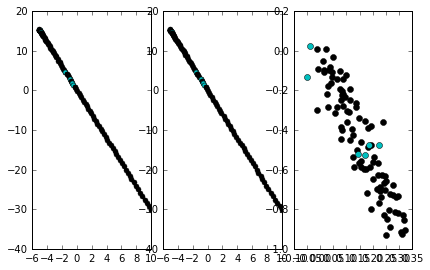

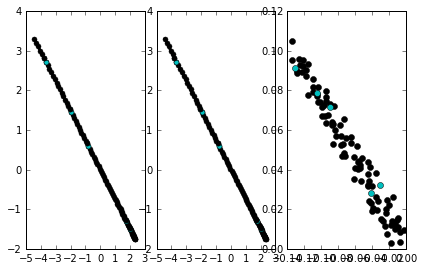

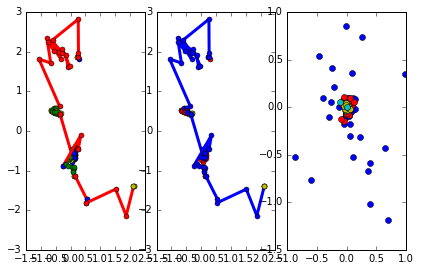

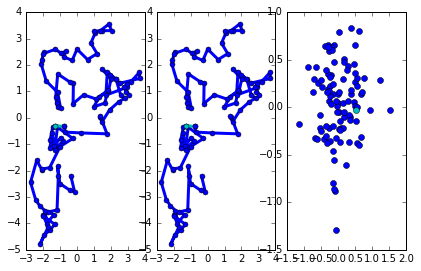

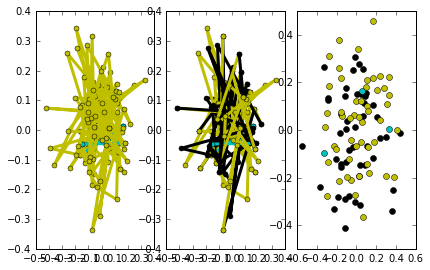

In [9]:
from Tools import plot_by_class,plot_label,plot_by_class
import copy
for w in range(10):
    res = copy.deepcopy(resp[w])
    res = np.argmax(res,axis=1)
    gt = np.argmax(Y_trains_b[w],axis=1)
    #print res
    #print gt
    print set(gt)
    #print resp[1][w][::,0]
    fig = figure()
    ax = fig.add_subplot(131)
    plot_label(scs[w],res,remove6=9)
    ax = fig.add_subplot(132)

    plot_label(scs[w],gt,remove6=9)
    ax = fig.add_subplot(133)

    
    plot_by_class(scs[w],np.array(gt))
"""
figure()
plot(resp[1][w][::,0])
plot(ret["sigma"][w][::,0])
"""

In [138]:
print ret["brownian"][w][:10]

[[ 1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]
